## Outline
In this notebook, we will explore the process of classifying Tumor Immune cells data using **QuPID** vectorization and a Vanilla Random Forest Classifier. The main steps include:


1. *Data Processing*: Preparing the data by computing persistent diagrams for $H_0$ and $H_1$ for each sample.
2. *Diagrams Embedding*: Each diagram from the dataset is embedded in a vector space using QuPID.
3. *Model Training and Evaluation*: Building and training a RandomForest classifier and assess the model's performance across different tasks.

In [1]:
import pandas as pd
import numpy as np
import qupid.utils as spu
from qupid.qupid import QuPID

### Data Processing
Here, we prepare the generated data for analysis by computing persistent diagrams for $H_0$ and $H_1$ homology groups for each sample. 

In [2]:
n_CD68 = 73
n_FoxP3 = 74
n_CD8 = 65

#CD68 -> 73
samplesCD68 = []
for i in range(n_CD68):
    df = pd.read_csv(f"./data/TIC+/TumourT_CCD6810NNCodensitySample{i+1}RipsMax1.txt",  skiprows=4, sep=" ", header=None, usecols=[0, 1]).to_numpy()
    samplesCD68.append(df)

#FoxP3->74
samplesFoxP3 = []
for i in range(n_FoxP3):
    df = pd.read_csv(f"./data/TIC+/TumourT_CFoxP310NNCodensitySample{i+1}RipsMax1.txt",  skiprows=4, sep=" ", header=None, usecols=[0, 1]).to_numpy()
    samplesFoxP3.append(df)

#CD8->65
samplesCD8 = []
for i in range(n_CD8):
    df = pd.read_csv(f"./data/TIC+/TumourT_CCD810NNCodensitySample{i+1}RipsMax1.txt",  skiprows=4, sep=" ", header=None, usecols=[0, 1]).to_numpy()
    samplesCD8.append(df)

In [3]:
spu.compute_tic_ph("CD68", samplesCD68)
spu.compute_tic_ph("CD8", samplesCD8)
spu.compute_tic_ph("FoxP3", samplesFoxP3)

Persistence computed for CD68
Persistence computed for CD8
Persistence computed for FoxP3


### Diagrams Embedding
In this step, each persistence diagram from the dataset is embedded in a vector space using the **QuPID** vectorization method. This transformation facilitates the application of machine learning algorithms by representing the complex topological data in a more accessible form.


In [4]:
diagrams_dicts = {
    "CD68": spu.get_tic_data("CD68"),
    "CD8": spu.get_tic_data("CD8"),
    "FoxP3": spu.get_tic_data("FoxP3")
}

samples_dict, H0_min, H0_max, H1_min, H1_max = spu.process_tic_dataset(diagrams_dicts)

In [5]:
function = "wvt"
wave = "coif2"
r = 20

# Initialize QuPID models
modelH0 = QuPID(function=function, resolution=(1, r), global_max=H0_max, global_min=H0_min, wave=wave, alpha=(0, 1e3))
modelH1 = QuPID(function=function, resolution=(r, r), global_max=H1_max, global_min=H1_min, wave=wave, alpha=(1e3, 5e3))

# Fit and transform data
transformed_data = {category: [] for category in samples_dict}
for category, (samples_H0, samples_H1) in samples_dict.items():
    for i in range(len(samples_H0)):
        modelH0.fit([samples_H0[i]])
        modelH1.fit([samples_H1[i]])
        transformed_data[category].append(np.concatenate((modelH0.transform(samples_H0[i]), modelH1.transform(samples_H1[i]))))

### Figure 4

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


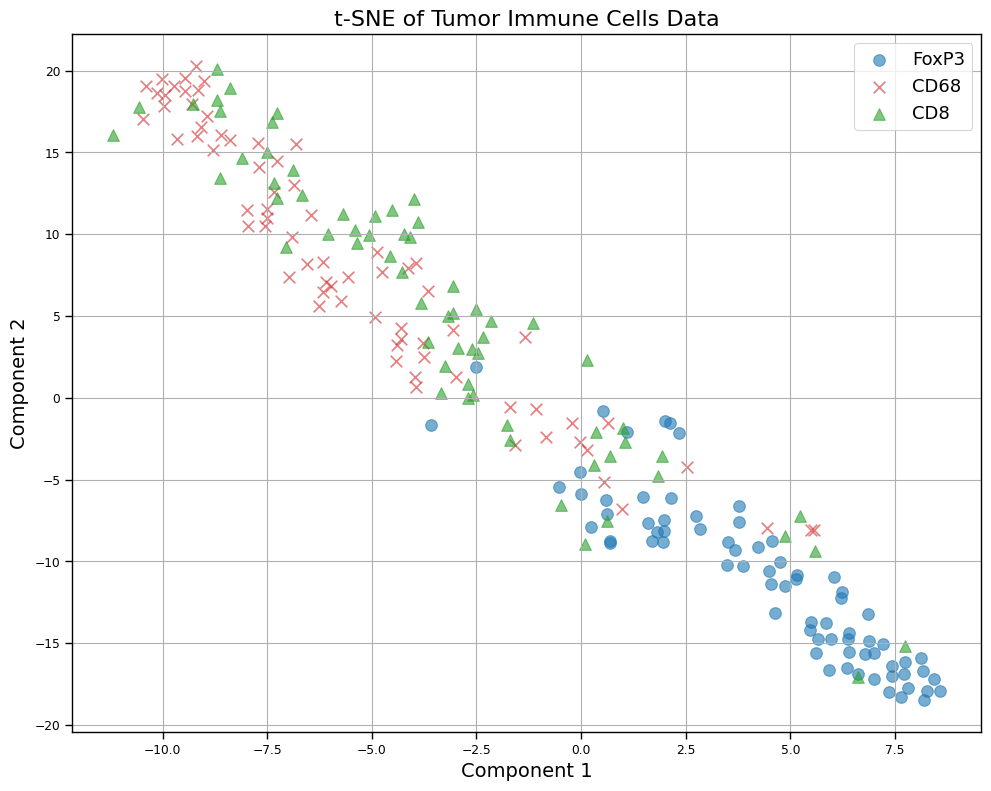

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Concatenate the data
FOX = np.concatenate([transformed_data["FoxP3"], transformed_data["CD68"], transformed_data["CD8"]], axis=0)


labels = np.concatenate([np.zeros((n_FoxP3)), np.ones(n_CD68), 2*np.ones(n_CD8)])

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(FOX)

# Define markers and palette
markers = ['o', 'x', '^']
palette = sns.color_palette(["#1f77b4", "#d62728", "#2ca02c"])  # Seaborn deep colors: blue, red, green

# Plot t-SNE results
plt.figure(figsize=(10, 8))
sns.set_context("paper")
names = ["FoxP3", "CD68", "CD8"]
for label, marker, color in zip(np.unique(labels), markers, palette):
    plt.scatter(X_tsne[labels == label, 0], X_tsne[labels == label, 1], 
                marker=marker, color=color, label=f'{names[int(label)]}', s = 70, alpha=0.6)
    

plt.title('t-SNE of Tumor Immune Cells Data', fontsize=16)
plt.xlabel('Component 1', fontsize=14)
plt.ylabel('Component 2', fontsize=14)
plt.legend(fontsize = 13)
plt.savefig("figure4tumor.png", dpi = 300)
plt.grid(True)
plt.tight_layout()
plt.show()